In [2]:
# declare a list tasks whose products you want to use as inputs
upstream = None


In [3]:
# Imports and Setup
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import logging
import json
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import importlib

# Add project root to path
sys.path.append(str(Path.cwd().parent))

# Import and reload modules to get fresh changes
from src.models.predictor import TrollPredictor
from src.data_tools.czech_data_tools import load_czech_media_data
from src.data_tools.czech_data_tools import export_comments_by_prediction
import src.models.predictor

# Configure matplotlib and seaborn
plt.style.use('default')
sns.set_theme()

In [4]:
DATA_DIR = Path('../data')

# Initialize predictor with model
model_path = "../checkpoints/best_model.pt" if 'model_path' not in locals() else "../" + model_path

predictor = TrollPredictor(
    model_path=model_path,
    comments_per_user=5,
    max_length=64
)

In [5]:
# Check if preprocessed data exists and load it, otherwise process from source
PROCESSED_DIR = DATA_DIR / 'processed'
PROCESSED_DIR.mkdir(exist_ok=True)
czech_media_parquet = PROCESSED_DIR / 'czech_media_comments.parquet'

if czech_media_parquet.exists():
    print(f"Loading preprocessed data from {czech_media_parquet}...")
    czech_comments = pd.read_parquet(czech_media_parquet)
else:
    print("Preprocessed data not found. Loading and processing from source...")
    czech_comments = load_czech_media_data(str(DATA_DIR / 'MediaSource'))
    # Save processed data (we'll keep cell 6 in case you want to save explicitly)
    czech_comments.to_parquet(czech_media_parquet)
    print(f"Preprocessed data saved to {czech_media_parquet}")

print(f"Loaded {len(czech_comments)} comments from {czech_comments['author'].nunique()} unique authors")

Loading preprocessed data from ../data/processed/czech_media_comments.parquet...
Loaded 845764 comments from 66590 unique authors


In [6]:
# Display data info
print("\nDataset columns:", czech_comments.columns.tolist())
print("\nSample of comments:")
print(czech_comments[['text', 'author', 'sentiment']].head())


Dataset columns: ['text', 'raw_text', 'author', 'timestamp', 'article_title', 'url', 'article_id', 'sentiment']

Sample of comments:
                                                text        author   sentiment
0                        Umí i něco jiného než lhát?   Jiří Mraček    Negative
1  Nezávislost na Rusku je lež jako věž z Ruska b...  Fiala Václav    Negative
2  Vsak jak jinak. Pořád si stěžovali, že se musí...   Jana Krejci     Neutral
3  Jedna reforma školství stíhá druhou, hlavně ab...   Jiří Flusek     Neutral
4  Frantisek LuftNaštěstí to vychází z logiky int...   Honza Novak  Ambivalent


In [7]:
# Count original number of authors and comments
total_authors = czech_comments['author'].nunique()
total_comments = len(czech_comments)
print(f"Loaded {total_comments} comments from {total_authors} unique authors")

# Filter authors with at least 5 comments
author_counts = czech_comments['author'].value_counts()
authors_with_min_5 = author_counts[author_counts >= 5].index
czech_comments = czech_comments[czech_comments['author'].isin(authors_with_min_5)]

# Count filtered number of authors and comments
filtered_authors = czech_comments['author'].nunique()
filtered_comments = len(czech_comments)
print(f"Filtered to {filtered_comments} comments from {filtered_authors} authors with at least 5 comments")
print(f"Removed {total_authors - filtered_authors} authors with fewer than 5 comments")

Loaded 845764 comments from 66590 unique authors
Filtered to 775578 comments from 25461 authors with at least 5 comments
Removed 41129 authors with fewer than 5 comments


In [ ]:
# Make predictions and save results
output_dir = Path('../output')
output_dir.mkdir(exist_ok=True)
cache_file = output_dir / 'results_df.pkl'

# Load cached results if available
# if cache_file.exists():
#     print(f"Loading cached results from {cache_file}...")
#     results_df = pd.read_pickle(cache_file)
# else:
#     print("No cached results found. Please run the prediction step first.")

results = []
for idx, group in tqdm(czech_comments.groupby('author')):
    texts = group['text'].tolist()
    
    # Get prediction
    pred = predictor.predict_batch(texts)
    
    # Store results
    results.append({
        'author': idx,
        'n_comments': len(texts),
        'prediction': pred['prediction'],
        'confidence': pred['confidence'],
        'troll_probability': pred['probabilities'][1]
    })

# Convert to DataFrame and cache it
results_df = pd.DataFrame(results)
results_df.to_pickle(cache_file)
print("results_df saved for future runs.")



100%|████████████████████████████████████████████████████████████████████████████| 25461/25461 [02:24<00:00, 176.75it/s]


results_df saved for future runs.


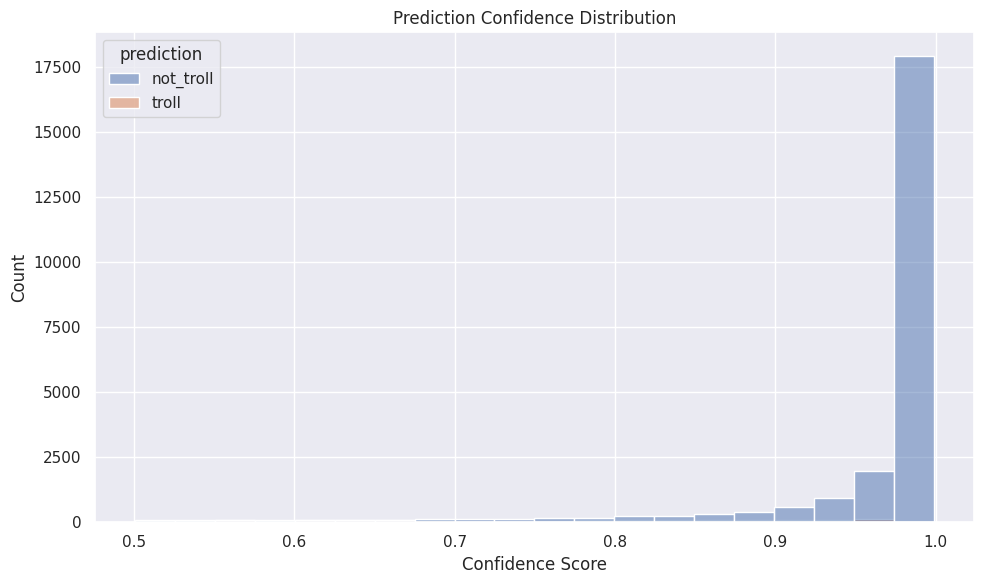

In [9]:
# Cell: Analyze predictions by confidence levels
# Create visualization
plt.figure(figsize=(10, 6))
sns.histplot(
    data=results_df, 
    x='confidence', 
    hue='prediction', 
    bins=20
)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()




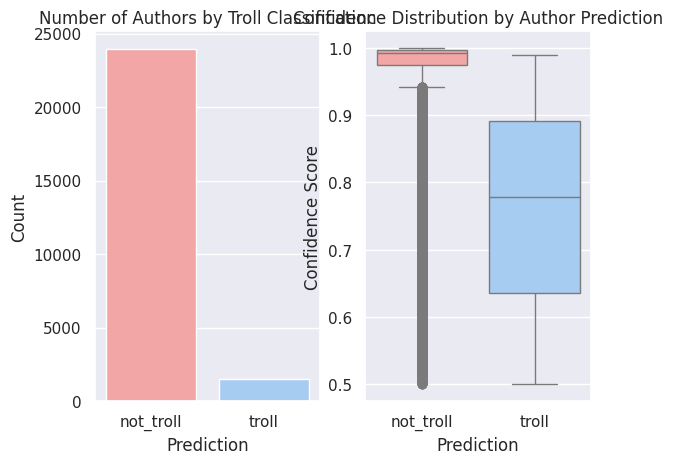

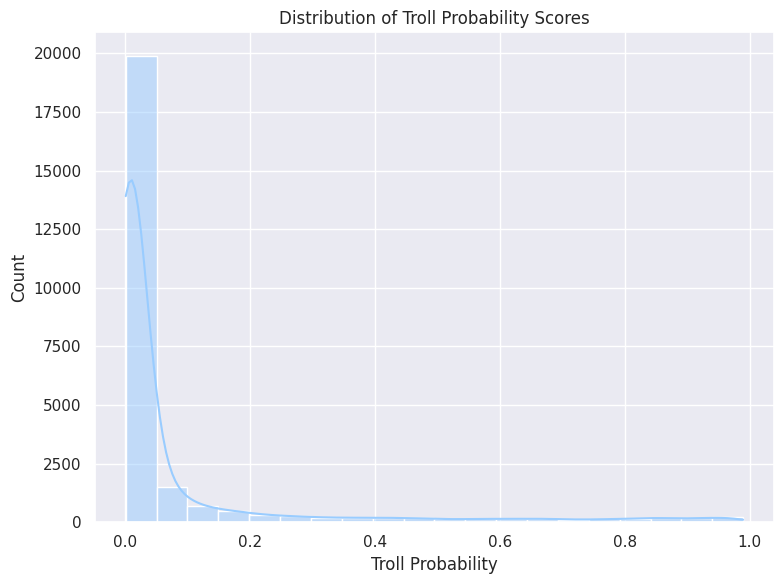

In [10]:
# Count plot of authors per prediction group
plt.subplot(1, 2, 1)
sns.countplot(data=results_df, x='prediction', hue='prediction', palette=['#FF9999','#99CCFF'],legend=False)
plt.title('Number of Authors by Troll Classification')
plt.xlabel('Prediction')
plt.ylabel('Count')

# Boxplot for confidence distribution per prediction group
plt.subplot(1, 2, 2)
sns.boxplot(data=results_df, x='prediction', hue='prediction', y='confidence', palette=['#FF9999','#99CCFF'], legend=False)
plt.title('Confidence Distribution by Author Prediction')
plt.xlabel('Prediction')
plt.ylabel('Confidence Score')

# Distribution of troll probability scores
plt.figure(figsize=(8, 6))
sns.histplot(data=results_df, x='troll_probability', bins=20, kde=True, color='#99CCFF', legend=False)
plt.title('Distribution of Troll Probability Scores')
plt.xlabel('Troll Probability')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [17]:
# Save a sample of troll and not_troll classified comments

export_comments_by_prediction(
    predictions_df=results_df,
    comments_df=czech_comments,
    prediction_class='troll',
    min_confidence=0.7,
    max_confidence=0.9,
    max_authors=50,
    output_file="../output/troll_comments.json"
)

export_comments_by_prediction(
    predictions_df=results_df,
    comments_df=czech_comments,
    prediction_class='not_troll',
    min_confidence=0.8,
    max_authors=50,
    output_file="../output/non_troll_comments.json"
)

TypeError: export_comments_by_prediction() got an unexpected keyword argument 'max_authors'

In [11]:
def explain_author(
    author_name: str, 
    predictor_instance: TrollPredictor, 
    comments_df: pd.DataFrame, 
    display_plots: bool = True,
):
    """Interactive function to explain why an author was classified as a troll using multiple methods"""
    
    # Get author's comments
    author_comments = comments_df[comments_df['author'] == author_name]['text'].tolist()
    
    if not author_comments:
        print(f'No comments found for author: {author_name}')
        return
        
    # Get prediction first
    pred = predictor_instance.predict_batch(author_comments)
    
    if pred['prediction'] != 'troll':
        print(f'Author {author_name} is not classified as a troll (confidence: {pred["confidence"]:.3f})')
        return
    
    print(f"\nAnalyzing author: {author_name}")
    print(f"Prediction confidence: {pred['confidence']:.3f}")
    print(f"Troll probability: {pred['probabilities'][1]:.3f}")
    
    # Generate occlusion sensitivity explanation
    print("\n=== Occlusion Sensitivity Analysis ===")
    explanation = predictor_instance.explain_prediction(author_comments)
    
    # Print occlusion sensitivity results
    for i, exp in enumerate(explanation['explanations'], 1):
        print(f"\nComment {i}:")
        print(f"Text: {exp['tweet_text']}")
        print("\nMost influential tokens (Occlusion Sensitivity):")
        
        # Create a table with token contributions
        contrib_data = []
        for contrib in exp['token_contributions']:
            direction = "Supporting" if contrib['contribution'] == 'positive' else "Opposing"
            contrib_data.append([
                contrib['token'],
                f"{contrib['importance']:.4f}",
                direction
            ])
        
        contrib_df = pd.DataFrame(contrib_data, columns=['Token', 'Importance', 'Effect'])
        print(contrib_df.to_string(index=False))
        
        if display_plots:
            img = plt.imread(exp['plot_filename'])
            plt.figure(figsize=(12, 4))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Occlusion Sensitivity Analysis - Comment {i}')
            plt.show()
        
        print("-" * 80)


Analyzing author: Vladimír Furrer
Prediction confidence: 0.897
Troll probability: 0.897

=== Occlusion Sensitivity Analysis ===

Generating explanations using occlusion sensitivity...

Processing tweet 1/5
Occlusion analysis for Tweet 1:
Text: …promluvil prodavač nutelly
Plot saved to: importance_tweet_1.png
Top contributing tokens:
  - '[UNK]': 0.0322 (supporting the prediction)
  - '##ml': -0.0132 (opposing the prediction)
  - 'nu': -0.0108 (opposing the prediction)
  - 'pro': 0.0100 (supporting the prediction)

Processing tweet 2/5
Occlusion analysis for Tweet 2:
Text: a podívejme se..plyn od Slovenska taky dobrý?
Plot saved to: importance_tweet_2.png
Top contributing tokens:
  - 'Slovenska': 0.0538 (supporting the prediction)
  - 'a': -0.0269 (opposing the prediction)
  - 'tak': -0.0211 (opposing the prediction)
  - '##ý': -0.0204 (opposing the prediction)
  - '##me': -0.0166 (opposing the prediction)
  - '##y': -0.0164 (opposing the prediction)
  - '.': -0.0164 (opposing the pred

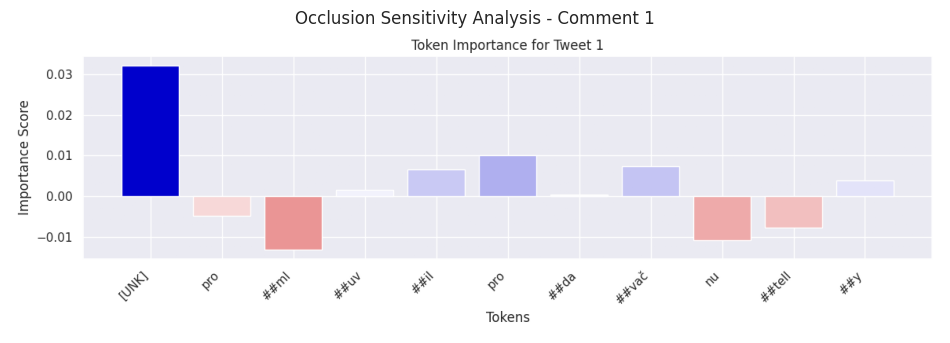

--------------------------------------------------------------------------------

Comment 2:
Text: a podívejme se..plyn od Slovenska taky dobrý?

Most influential tokens (Occlusion Sensitivity):
    Token Importance     Effect
Slovenska     0.0538 Supporting
        a    -0.0269   Opposing
      tak    -0.0211   Opposing
      ##ý    -0.0204   Opposing
     ##me    -0.0166   Opposing
      ##y    -0.0164   Opposing
        .    -0.0164   Opposing
      dob    -0.0152   Opposing
        .    -0.0137   Opposing
      ##r    -0.0136   Opposing


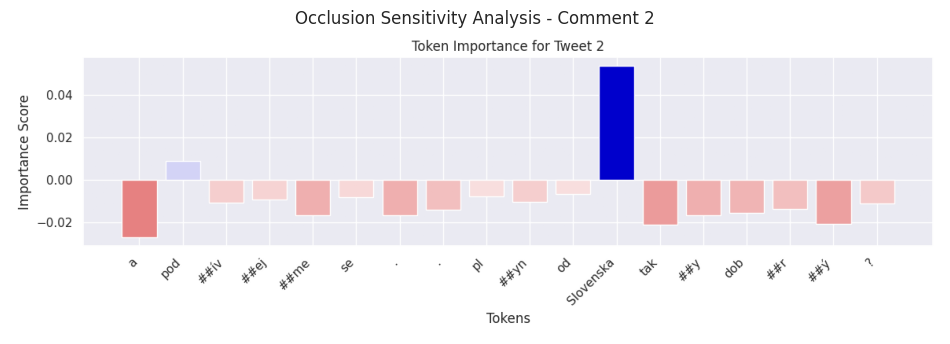

--------------------------------------------------------------------------------

Comment 3:
Text: A kde byla ta jeho..vždyt je nyní za to placená?

Most influential tokens (Occlusion Sensitivity):
Token Importance     Effect
    .    -0.0427   Opposing
    .    -0.0398   Opposing
 byla     0.0326 Supporting
 vždy    -0.0315   Opposing
   ta    -0.0280   Opposing
 nyní    -0.0250   Opposing
 jeho     0.0242 Supporting
   to    -0.0200   Opposing
    ?     0.0128 Supporting
 ##ná    -0.0119   Opposing


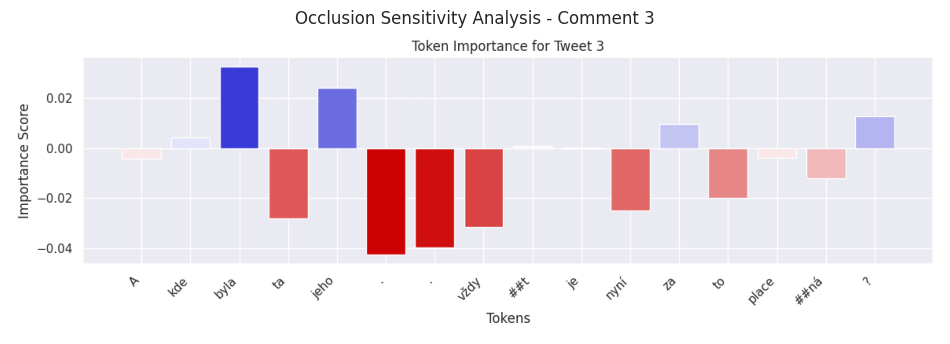

--------------------------------------------------------------------------------

Comment 4:
Text: Počátky demence..

Most influential tokens (Occlusion Sensitivity):
Empty DataFrame
Columns: [Token, Importance, Effect]
Index: []


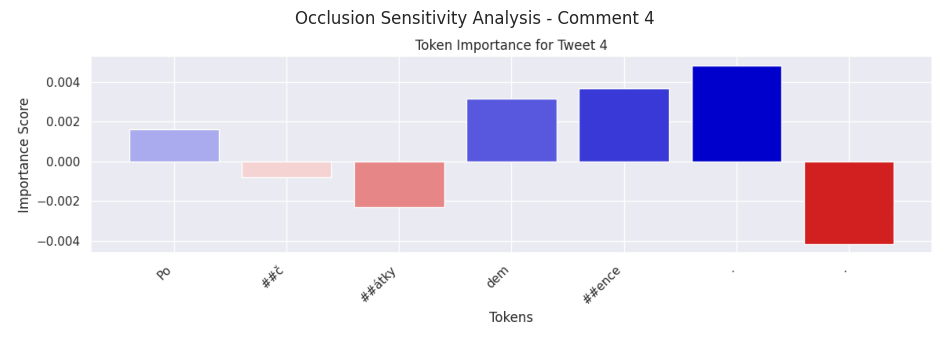

--------------------------------------------------------------------------------

Comment 5:
Text: no to snad není pravda…

Most influential tokens (Occlusion Sensitivity):
Token Importance     Effect
[UNK]     0.8812 Supporting
   to     0.0881 Supporting
   no    -0.0293   Opposing
  sna     0.0101 Supporting


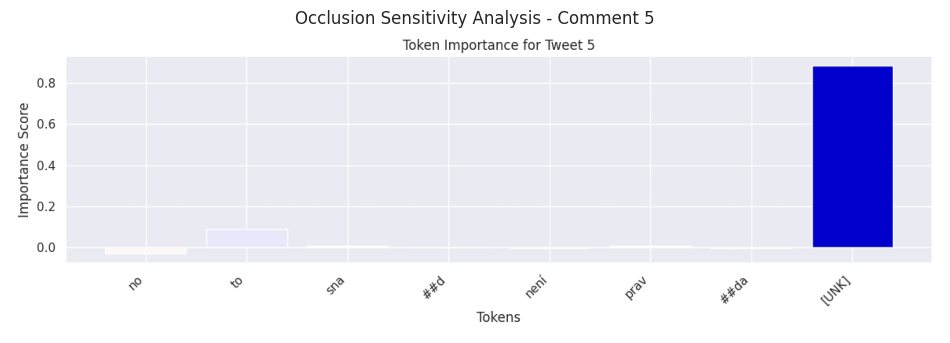

--------------------------------------------------------------------------------



Analyzing author: Michal Markó
Prediction confidence: 0.893
Troll probability: 0.893

=== Occlusion Sensitivity Analysis ===

Generating explanations using occlusion sensitivity...

Processing tweet 1/5
Occlusion analysis for Tweet 1:
Text: Ať si Ukrajinci pomohou doma a ne se rou se do jiného státu
Plot saved to: importance_tweet_1.png
Top contributing tokens:
  - '##ť': -0.0120 (opposing the prediction)

Processing tweet 2/5
Occlusion analysis for Tweet 2:
Text: Takže SPD nemusz vydat na volební kampaň ani korunu. Vládní koalice mu jí zaplatila.
Plot saved to: importance_tweet_2.png
Top contributing tokens:
  - 'SPD': 0.0699 (supporting the prediction)
  - '##ali': 0.0266 (supporting the prediction)
  - 'za': 0.0116 (supporting the prediction)
  - 'jí': -0.0101 (opposing the prediction)

Processing tweet 3/5
Occlusion analysis for Tweet 3:
Text: Větší blábol jsem nečetl. Ale každý se musí nějak živit.

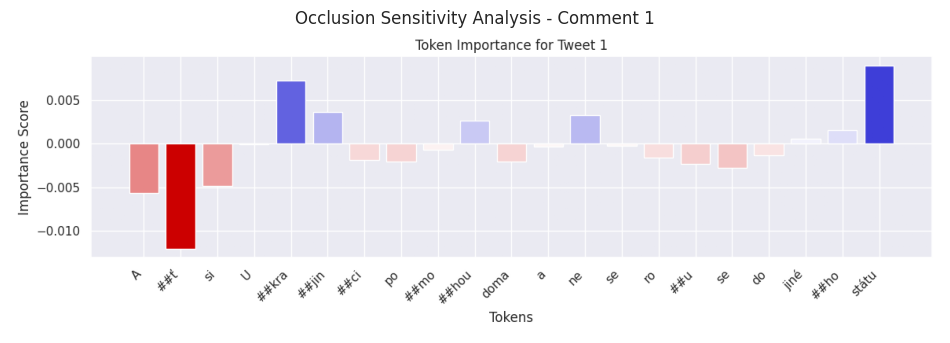

--------------------------------------------------------------------------------

Comment 2:
Text: Takže SPD nemusz vydat na volební kampaň ani korunu. Vládní koalice mu jí zaplatila.

Most influential tokens (Occlusion Sensitivity):
Token Importance     Effect
  SPD     0.0699 Supporting
##ali     0.0266 Supporting
   za     0.0116 Supporting
   jí    -0.0101   Opposing


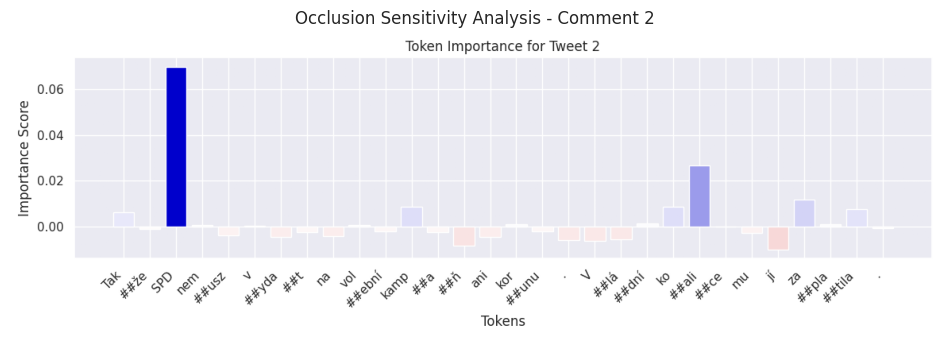

--------------------------------------------------------------------------------

Comment 3:
Text: Větší blábol jsem nečetl. Ale každý se musí nějak živit.

Most influential tokens (Occlusion Sensitivity):
Token Importance     Effect
    .     0.0347 Supporting
 jsem    -0.0213   Opposing
   se     0.0198 Supporting
  Ale     0.0171 Supporting
každý    -0.0122   Opposing
 ##ší    -0.0114   Opposing
 živi     0.0107 Supporting


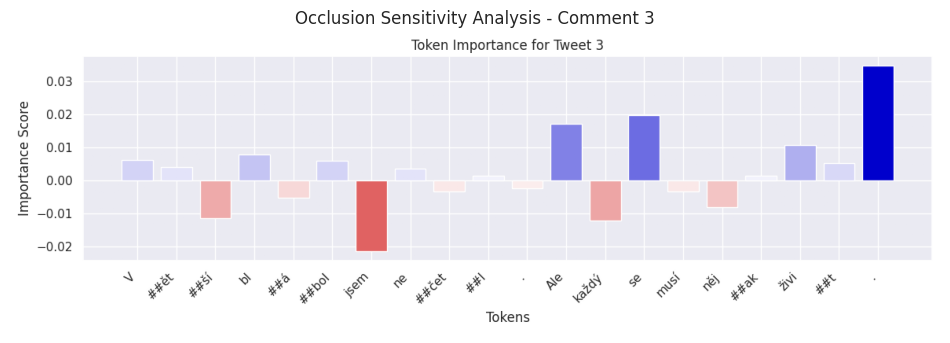

--------------------------------------------------------------------------------

Comment 4:
Text: Václav SchwarzV pražské kavárně

Most influential tokens (Occlusion Sensitivity):
  Token Importance     Effect
 Václav     0.1195 Supporting
Schwarz     0.0857 Supporting
    ##V     0.0263 Supporting
 ##žské     0.0164 Supporting


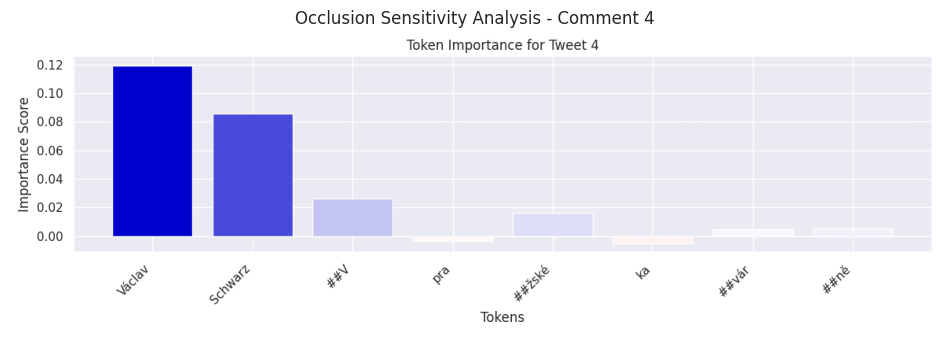

--------------------------------------------------------------------------------

Comment 5:
Text: Jiří PařízekHlavně, že to docenite Vy.

Most influential tokens (Occlusion Sensitivity):
Token Importance   Effect
  ##y    -0.0130 Opposing
    .    -0.0104 Opposing


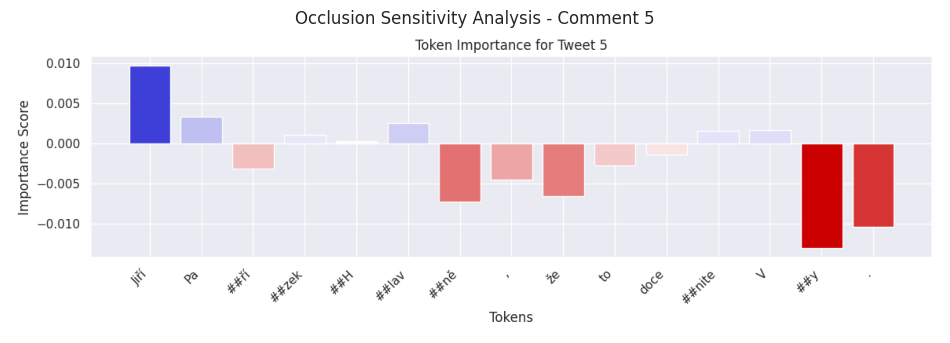

--------------------------------------------------------------------------------




In [12]:
# Example usage
# authors_to_explain = [
#     "Jitka Bártová",
#     "Roman Myška",   
# ]
authors_to_explain = [
    "Vladimír Furrer",
    "Michal Markó",   
]


for author in authors_to_explain:
    explain_author(
        author_name=author,
        predictor_instance=predictor,
        comments_df=czech_comments,
        display_plots=True,
    )
    print("\n" + "="*80 + "\n")